# Project Notebook

### Geo-Data Interpretation

loading libraries

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
# load csv and isolate data (1 min load)
df = pd.read_csv('/home/cohenrique/classes/cse151b/Project/train.csv')

In [3]:
# we see that trip_id carries no unique information
((df['TRIP_ID']-df['TAXI_ID']-df['TIMESTAMP']*1e9)/1e8).astype('int').unique()

array([6])

In [4]:
# daytype only have one value, so also unnecessary
df['DAY_TYPE'].unique()

array(['A'], dtype=object)

In [5]:
# so we drop the above data 'missing_data' is take care of through subsequent processing
df = df.drop(['TRIP_ID','MISSING_DATA', 'DAY_TYPE'], axis=1)

In [6]:
# simplifies each unique taxi_id to a smaller, more sequential value, still unique.
def clean_taxi_id(id):
    id -= 2e7
    if id > 700:
        id -= 200
    return int(id)

In [7]:
df['TAXI_ID'] = df['TAXI_ID'].apply(clean_taxi_id)

# First pass of cleaning of our data

In [8]:
from datetime import datetime
# this function was borrowed from discussion notes
def parse_time(x):
  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.month, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df[["MON", "HR", "WK"]] = df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [9]:
df = df.drop(['TIMESTAMP'], axis = 1)

# Strat notes
* call_type b no origin_call, 64 origin_stand
* call_type a 57105 origin_call, no origin_stand

In [10]:
np.random.seed(1887)
dfs = df
#dfs = df.sample(1000)

In [11]:
df.shape[0], dfs.shape[0]

(1710670, 1710670)

## Notes
* We decided to allow the missing data to be processed by our own filter which filters out updates that break past 100mph distance traveled
    * where we note that all missing data instance are taken care of through that filter
* we note that the TRIP_ID is a useless value since it is a concatenation of TIME_STAMP6TAXI_ID so we remove it

In [12]:
from shapely.geometry import LineString

In [13]:
# Notes: via our skip processing, we discard about 0.25% of our data based on 25 random samples at 1000 each size
# Output:
# trip_duration (in sec as int), start_loc (Point), end_loc (Point), valid (bool), linestring (LineString)
def process_polyline(poly):
    poly = eval(poly['POLYLINE']) # polyline comes as string, we eval it as a list and then convert to np.array
    linestring = []
    valid = True
    min_length = 3
    count = 0
    skip_count = 0
    skip_threshold = 1
    max_skip_count = 0
    error_count = 0

    for x, y in poly:
        linestring.append(Point(x,y))
        count += 1
        if len(linestring) > 1:
            if (linestring[-2].distance(linestring[-1]) > (skip_count+1)/180):     # approximation for 80mph @1/14400 per mph
                linestring.pop()
                skip_count += 1
                error_count += 1
                if skip_count > skip_threshold:
                    valid = False
            else:
                if skip_count == 0:                 # no skips, just continue
                    continue
                elif skip_count <= skip_threshold:                               # replace missing points with approximations
                    new = linestring.pop()
                    old = linestring[-1]
                    x_delta = (new.x - old.x) / (skip_count + 1)
                    y_delta = (new.y - old.y) / (skip_count + 1)
                    for i in range(1,skip_count+1):
                        linestring.append(Point(round((old.x + x_delta*i),6),round((old.y + y_delta*i),6)))
                    linestring.append(new)
                    if (skip_count > max_skip_count):
                        max_skip_count = skip_count
                    skip_count = 0

    if (skip_count > max_skip_count):
        max_skip_count = skip_count
    duration = count * 15
    if len(linestring) >= min_length:
        start_loc, end_loc = linestring[0], linestring[-1]
        linestring = LineString(linestring)
    else:
        valid = False
        linestring = None
        start_loc, end_loc = None, None
    
    # can return bounds linestring.bounds returns (minx,miny,maxx,maxy)
    return start_loc, end_loc, duration, valid, max_skip_count, error_count, linestring


In [14]:
dfs[['START_LOC', 'END_LOC', 'TRIP_DURATION', 'VALID_DATA', 'MAX_SKIP', 'ERROR_COUNT', 'geometry']] = dfs[['POLYLINE']].apply(process_polyline, axis=1, result_type="expand")

In [15]:
#dfs = dfs.drop(['POLYLINE'], axis = 1)
dfs = dfs.drop(['POLYLINE', 'MAX_SKIP', 'ERROR_COUNT'], axis = 1)

### Filtering our Data

In [16]:
from pyproj import CRS

In [17]:
# creating the geopandas data frame, this will allow us to
# interpret the data as gps data, which we intended
      # take valid data only
loc_crs = CRS('EPSG:4326')
geo_df = gpd.GeoDataFrame(dfs[dfs['VALID_DATA']], crs=loc_crs)
geo_df = geo_df.drop(['VALID_DATA'], axis=1)
print("discard rate: ", 1 - geo_df.shape[0]/dfs.shape[0])
geo_df_bak = geo_df
geo_df.head()

discard rate:  0.08199360484488538


,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,MON,HR,WK,START_LOC,END_LOC,TRIP_DURATION,geometry
0,C,NaN,NaN,589,6,17,6,POINT (-8.618643 41.141412),POINT (-8.630838 41.154489),345,"LINESTRING (-8.61864 41.14141, -8.61850 41.141..."
1,B,NaN,7.0,596,6,17,6,POINT (-8.639847 41.159826),POINT (-8.66574 41.170671),285,"LINESTRING (-8.63985 41.15983, -8.64035 41.159..."
4,C,NaN,NaN,337,6,17,6,POINT (-8.645994 41.18049),POINT (-8.687268 41.178087),435,"LINESTRING (-8.64599 41.18049, -8.64595 41.180..."
5,C,NaN,NaN,231,6,17,6,POINT (-8.615502 41.140674),POINT (-8.578224 41.160717),390,"LINESTRING (-8.61550 41.14067, -8.61485 41.140..."
6,C,NaN,NaN,456,6,17,6,POINT (-8.57952 41.145948),POINT (-8.603973 41.142816),540,"LINESTRING (-8.57952 41.14595, -8.58094 41.145..."


### Prepare data for R export

In [18]:
def parse_point(x):
    start_pts = x['START_LOC']
    end_pts = x['END_LOC']
    return start_pts.x, start_pts.y, end_pts.x, end_pts.y

In [19]:
geo_df[['START_X', 'START_Y', 'END_X', 'END_Y']] = geo_df[['START_LOC','END_LOC']].apply(parse_point, axis=1, result_type='expand')

In [20]:
geo_df['ORIGIN_CALL'] = geo_df['ORIGIN_CALL'].replace(np.nan, 0).astype('int')
geo_df['ORIGIN_STAND'] = geo_df['ORIGIN_STAND'].replace(np.nan, 0).astype('int')

In [21]:
geo_df = geo_df.drop(['START_LOC', 'END_LOC', 'geometry'], axis=1)
geo_df.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,MON,HR,WK,TRIP_DURATION,START_X,START_Y,END_X,END_Y
0,C,0,0,589,6,17,6,345,-8.618643,41.141412,-8.630838,41.154489
1,B,0,7,596,6,17,6,285,-8.639847,41.159826,-8.665740,41.170671
4,C,0,0,337,6,17,6,435,-8.645994,41.180490,-8.687268,41.178087
5,C,0,0,231,6,17,6,390,-8.615502,41.140674,-8.578224,41.160717
6,C,0,0,456,6,17,6,540,-8.579520,41.145948,-8.603973,41.142816


In [22]:
# All outlier boundaries were determined by mean/sd of each feature at +/- 4sds from the mean rounded to 2 decimal places for simplicity
x_min, x_max, y_min, y_max = -8.75, -8.49, 41.06, 41.27
geo_df = geo_df[(geo_df['TAXI_ID'] < 705) &
                (geo_df['TRIP_DURATION'] > 45) & (geo_df['TRIP_DURATION'] < 6600) &
                (geo_df['START_X'] > x_min) & (geo_df['END_X'] > x_min) &
                (geo_df['START_X'] < x_max) & (geo_df['END_X'] < x_max) &
                (geo_df['START_Y'] > y_min) & (geo_df['END_Y'] > y_min) &
                (geo_df['START_Y'] < y_max) & (geo_df['END_Y'] < y_max) ]

In [23]:
geo_df.to_csv('out.csv', index=False)  

In [24]:
geo_df2 = geo_df[geo_df['CALL_TYPE'] == 'C']
#geo_df2 = geo_df[geo_df['TRIP_DURATION'] < dur_lim]
#geo_df2['test'] = geo_df2['ORIGIN_CALL'].between(5000,6000)

In [25]:
geo_df = pd.read_pickle('geo_df_bak.pkl')

In [26]:
#geo_df2 = geo_df[geo_df['TRIP_DURATION'] == 45]
geo_df2 = geo_df.sample(15000)
#geo_df2 = geo_df[geo_df['TRIP_DURATION'] < dur_lim]
#geo_df2['test'] = geo_df2['ORIGIN_CALL'].between(5000,6000)
#geo_df2['test'] = geo_df2['TRIP_DURATION'] == 45

In [27]:
geo_df.shape[0]

1558116

In [28]:
geo_df2.shape[0]

15000

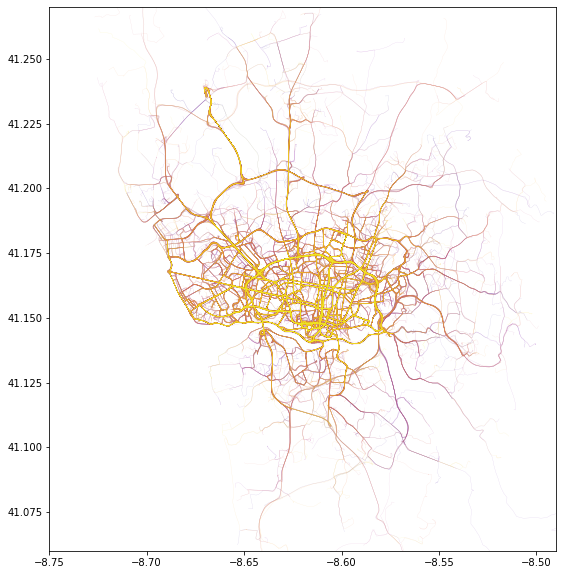

In [29]:
# TODO: generate a heatmap
# TODO: add region overlay figure
#geo_df['color'] = gps2.ORIGIN_STAND
#column=geo_df2['test'], alpha = 30/geo_df2.shape[0]

#ax = geo_df2[geo_df2['test']].plot(figsize = (10,10), alpha=0.67, linewidth=0.5, cmap='plasma')
ax = geo_df2.plot(figsize = (10,10), alpha=0.2, linewidth=0.25, cmap='plasma')
#ax = geo_df2.plot(ax = ax, column=dfs['CALL_TYPE'], legend=True, markersize=0.5)
ax.set_ylim([y_min, y_max])
ax.set_xlim([x_min, x_max])
plt.savefig('filename.png', dpi=1080)

### Storing our Data (Pickling)

#### save

In [47]:
# pickling our geo_df geo_dataframe
geo_df.to_pickle("geo_df.pkl")

#### load

In [147]:
new_df = pd.read_pickle('geo_df_bak.pkl')